### Group ID: DRL Group 150
### Group Members Name with Student ID:
1. HEMANT KUMAR PARAKH (2023aa05741)
2. SUSHIL KUMAR (2023aa05849)
3. NAGINENI SATISH BABU (2023aa05585)
4. JITENDRA KUMAR (2023aa05198)


# Problem Statement

The objective of the problem is to implement an Actor-Critic reinforcement learning algorithm to optimize energy consumption in a building. The agent should learn to adjust the temperature settings dynamically to minimize energy usage while maintaining comfortable indoor conditions.

#### Dataset Details
Dataset: https://archive.ics.uci.edu/dataset/374/appliances+energy+prediction

This dataset contains energy consumption data for a residential building, along with various environmental and operational factors.

Data Dictionary:
* Appliances:       Energy use in Wh
* lights:           Energy use of light fixtures in the house in Wh
* T1 - T9:          Temperatures in various rooms and outside
* RH_1 to RH_9:     Humidity measurements in various rooms and outside
* Visibility:       Visibility in km
* Tdewpoint:       Dew point temperature
* Pressure_mm_hgg:  Pressure in mm Hg
* Windspeed:        Wind speed in m/s

#### Environment Details
**State Space:**
The state space consists of various features from the dataset that impact energy consumption and comfort levels.

* Current Temperature (T1 to T9): Temperatures in various rooms and outside.
* Current Humidity (RH_1 to RH_9): Humidity measurements in different locations.
* Visibility (Visibility): Visibility in meters.
* Dew Point (Tdewpoint): Dew point temperature.
* Pressure (Press_mm_hg): Atmospheric pressure in mm Hg.
* Windspeed (Windspeed): Wind speed in m/s.

Total State Vector Dimension: Number of features = 9 (temperature) + 9 (humidity) + 1 (visibility) + 1 (dew point) + 1 (pressure) + 1 (windspeed) = 22 features

**Target Variable:** Appliances (energy consumption in Wh).

**Action Space:**
The action space consists of discrete temperature adjustments:
* Action 0: Decrease temperature by 1°C
* Action 1: Maintain current temperature
* Action 2: Increase temperature by 1°C


- If the action is to decrease the temperature by 1°C, you'll adjust each temperature feature (T1 to T9) down by 1°C.
- If the action is to increase the temperature by 1°C, you'll adjust each temperature feature (T1 to T9) up by 1°C.
- Other features remain unchanged.

**Policy (Actor):** A neural network that outputs a probability distribution over possible temperature adjustments.

**Value function (Critic):** A neural network that estimates the expected cumulative reward (energy savings) from a given state.

**Reward function:**
The reward function should reflect the overall comfort and energy efficiency based on all temperature readings. i.e., balance between minimising temperature deviations and minimizing energy consumption.

* Calculate the penalty based on the deviation of each temperature from the target temperature and then aggregate these penalties.
* Measure the change in energy consumption before and after applying the RL action.
* Combine the comfort penalty and energy savings to get the final reward.

*Example:*

Target temperature=22°C

Initial Temperatures: T1=23, T2=22, T3=21, T4=23, T5=22, T6=21, T7=24, T8=22, T9=23

Action Taken: Decrease temperature by 1°C for each room

Resulting Temperatures: T1 = 22, T2 = 21, T3 = 20, T4 = 22, T5 = 21, T6 = 20, T7 = 23, T8 = 21, T9 = 22

Energy Consumption: 50 Wh (before RL adjustment) and 48 Wh (after RL adjustment)
* Energy Before (50 Wh): Use the energy consumption from the dataset at the current time step.
* Energy After (48 Wh): Use the energy consumption from the dataset at the next time step (if available).

Consider only temperature features for deviation calculation.

Deviation = abs (Ti− Ttarget )

Deviations=[ abs(22−22), abs(21−22), abs(20−22), abs(22−22),  abs(21−22), abs(20−22), abs(23−22), abs(21−22), abs(22−22) ]

Deviations = [0, 1, 2, 0, 1, 2, 1, 1, 0], Sum of deviations = 8

Energy Savings = Energy Before−Energy After = 50 – 48 = 2Wh

Reward= −Sum of Deviations + Energy Savings = -8+6 = -2

#### Expected Outcomes
1. Pre-process the dataset to handle any missing values and create training and testing sets.
2. Implement the Actor-Critic algorithm using TensorFlow.
3. Train the model over 500 episodes to minimize energy consumption while maintaining an indoor temperature of 22°C.
4. Plot the total reward obtained in each episode to evaluate the learning progress.
5. Evaluate the performance of the model on test set to measure its performance
6. Provide graphs showing the convergence of the Actor and Critic losses.
7. Plot the learned policy by showing the action probabilities across different state values (e.g., temperature settings).
8. Provide an analysis on a comparison of the energy consumption before and after applying the reinforcement learning algorithm.


#### Code Execution

### Imports

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gc
import random

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Installation of Pytorch libs

In [5]:
!pip install torchinfo
from torchinfo import summary

### Mount google drive to load dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Load Dataset
2. Check and fill missing values with mean
3. Defining X and y Data as features and target respectively
4. Data normalization and scalling
5. Splitting data for train and test


In [7]:
#### Load the dataset
try:
  # Load the dataset
  file_path = '/content/energydata_complete.csv'
  df = pd.read_csv(file_path)
except:
  # Load the dataset
  file_path = '/content/drive/MyDrive/Colab Notebooks/DRL-assignment-2/energydata_complete.csv'
  df = pd.read_csv(file_path)

print("dataset size = ", df.shape)

#data = df.sample(frac=0.01, random_state=42)  # Sampling for quicker processing
#print("Reduced % of dataset size = ", data.shape)

data = df.copy()


# Check and replace missing values
numeric_data = data.select_dtypes(include=np.number)
data.fillna(numeric_data.mean(), inplace=True)

# Preprocess the data
features = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9',
            'RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9',
            'Visibility', 'Tdewpoint', 'Press_mm_hg', 'Windspeed']
target = ['Appliances']

X = data[features]
y = data[target]

# Normalize them with Standard Scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data to training and testing sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

dataset size =  (19735, 29)
X_train shape: (15788, 22), y_train shape: (15788, 1)
X_test shape: (3947, 22), y_test shape: (3947, 1)


#Data Visulization

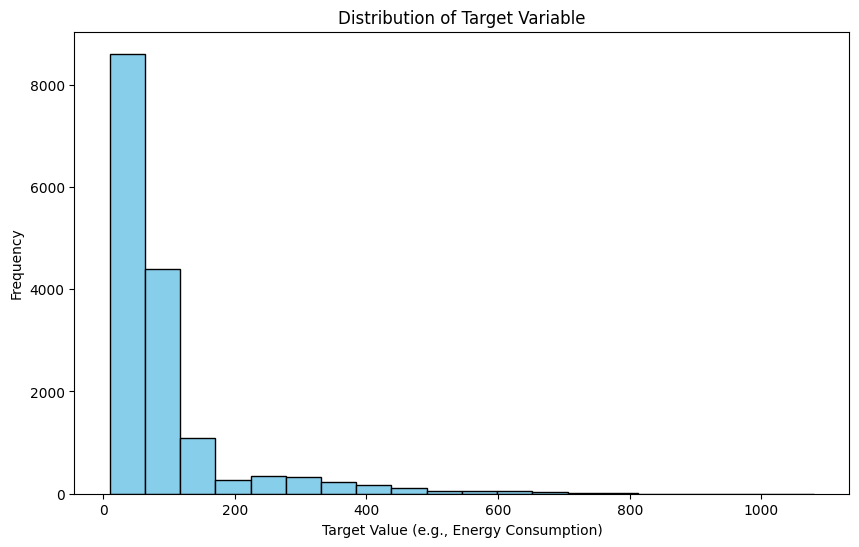

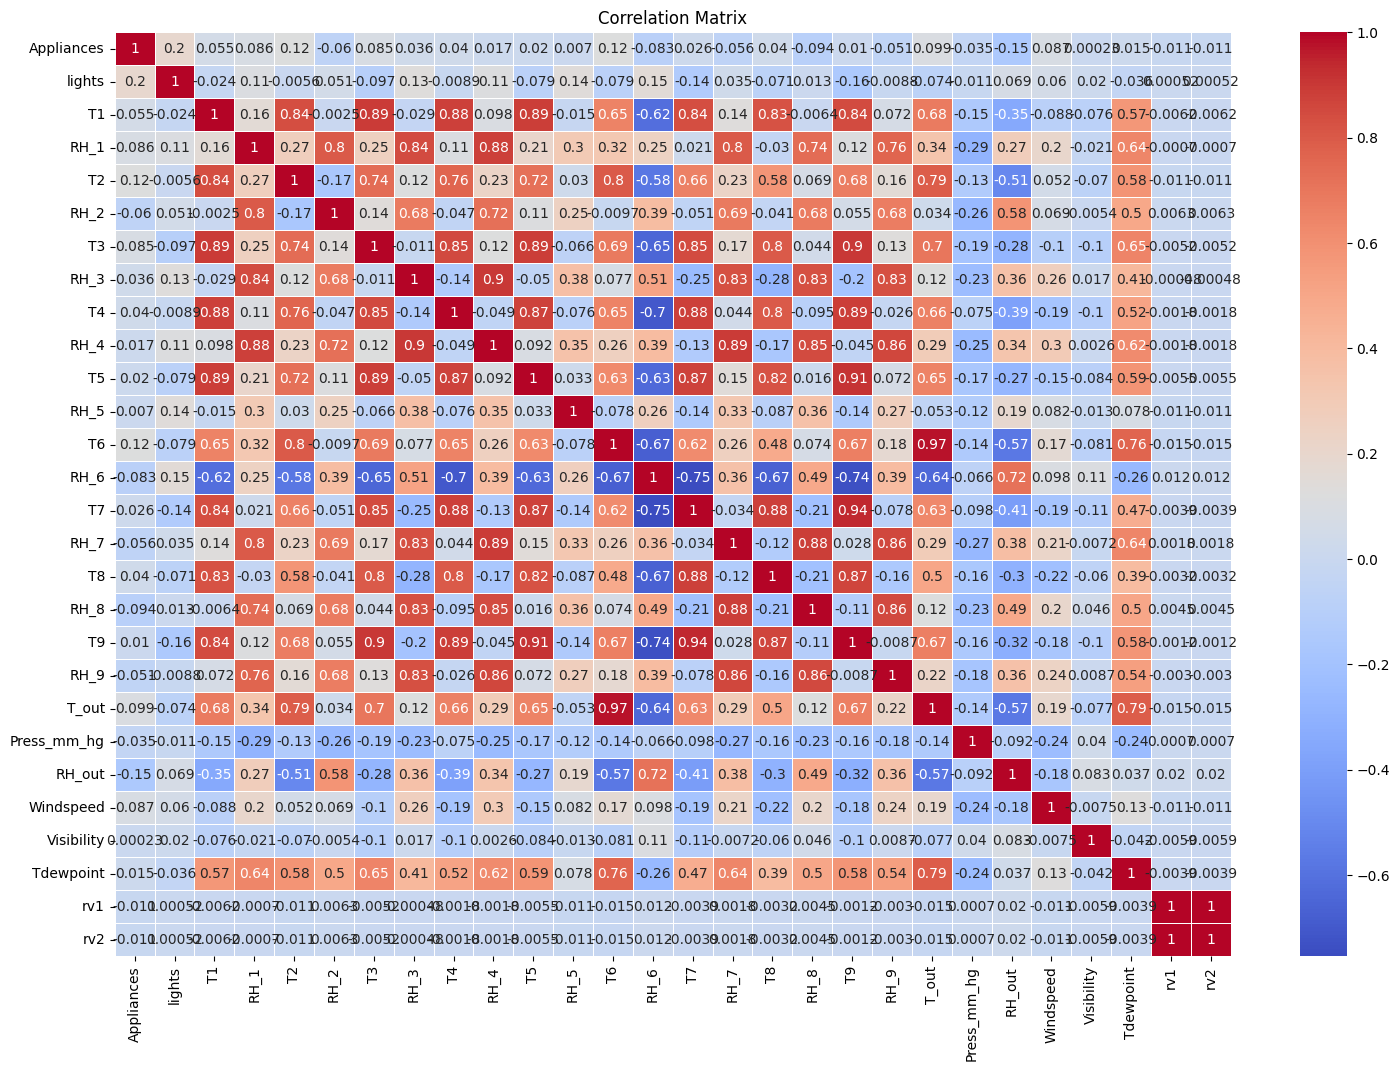

In [8]:
import matplotlib.pyplot as plt

def plot_target_distribution(y):
    plt.figure(figsize=(10, 6))
    plt.hist(y, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Target Variable')
    plt.xlabel('Target Value (e.g., Energy Consumption)')
    plt.ylabel('Frequency')
    plt.show()

# Assuming y_train contains the target values for the training set
plot_target_distribution(y_train)


import seaborn as sns

def plot_correlation_matrix(data):
    plt.figure(figsize=(18, 12))
    correlation_matrix = data.drop('date', axis=1).corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

# Assuming 'data' is the complete dataset including the target column
plot_correlation_matrix(data)





### Create an EnergyConsumption Environment (1 M)

Creating Energy Consumption environment with required action and rewards function

In [9]:
### write your code below this line

max_steps_per_episode = 200  # or any reasonable number

# Normalization of reward with mean and SD
class NormalizedRewards:
    def __init__(self, alpha=0.001, beta=0.001):
        self.rewards = []
        self.alpha = alpha  # Smoothing factor for mean
        self.beta = beta    # Smoothing factor for std
        self.mean_reward = 0
        self.std_reward = 1

    def update(self, reward):
        # Maintain a running estimate of the mean and std deviation
        self.mean_reward = self.alpha * reward + (1 - self.alpha) * self.mean_reward
        self.std_reward = self.beta * np.abs(reward - self.mean_reward) + (1 - self.beta) * self.std_reward

    def normalize(self, reward):
        self.update(reward)
        # Normalize the reward using the running mean and std
        return (reward - self.mean_reward) / (self.std_reward + 1e-5)

# Energy Consumptio Environment
class EnergyConsumptionEnv:
    def __init__(self, data, target_temp=22, max_steps=200):
        # Initializing the environment with data
        self.data = data
        self.target_temp = target_temp
        self.max_steps = max_steps  # Set the max steps per episode
        # Define the state space (features) and action space
        self.state_space = data.shape[1]  # State space size (number of features)
        self.action_space = 3  # Three possible actions (decrease, maintain, increase temp)
        self.reward_normalizer = NormalizedRewards(alpha=0.001, beta=0.001)

        # Keep track of the current step in the dataset
        self.current_step = 0

    # reset environment
    def reset(self):
        """Resets the environment to the initial state"""
        self.current_step = 0
        return self.data.iloc[self.current_step, :].values

    # Step function to define the actions and move to next state
    def step(self, action):
        """Take an action (0, 1, 2) and move to the next state"""

        # Extract the current state from the dataset
        #print(f"Current step: {self.current_step}, Data length: {len(self.data)}")
        if 0 <= self.current_step < len(self.data):
            current_state = self.data.iloc[self.current_step, :].values
        else:
            #print(f"Current step after: {self.current_step}, Data length: {len(self.data)}")
            current_state = None
            return None, 0, True

        # Determine the next step (either increment by 1 or stop at the end of the data)
        next_step = min(self.current_step + 1, len(self.data) - 1)
        next_state = self.data.iloc[next_step, :].values

        # Apply the action to the first 9 temperature features (T1-T9)
        for i in range(9):
            if action == 0:  # Decrease temperature
                next_state[i] -= 1
            elif action == 2:  # Increase temperature
                next_state[i] += 1

        # Calculate the reward based on energy savings and temperature deviation
        reward = self.calculate_reward(current_state, next_state)

        # Increment the step count after taking an action
        if self.current_step < len(self.data):
            self.current_step += 1
        else:
            # Handle end of episode (e.g., set done = True)
            done = True

        # Determine if the episode is done (either at the end of data or maximum steps reached)
        done = self.current_step >= len(self.data) - 1 or self.current_step >= self.max_steps

        # Debugging output to track the termination conditions
        #print(f"Step {self.current_step}, Max steps: {self.max_steps}, Data length: {len(self.data)}")
        #print(f"Step taken, Done: {done}, Step count: {self.current_step}/{self.max_steps}")

        # Return the next state, the reward, and the done flag
        return next_state, reward, done

    # Reward calculations
    def calculate_reward(self, current_state, next_state):
        """Calculates the reward based on energy savings and comfort"""
        if current_state is None or next_state is None:
            return 0  # Handle invalid state with a default reward

        # Proceed with normal reward calculation if state is valid
        # Extract energy consumption (last column of the state)
        energy_before = current_state[-1]
        energy_after = next_state[-1]
        energy_savings = current_state[-1] - next_state[-1]

        # Calculate temperature deviations from the target
        deviations = np.abs(next_state[:9] - self.target_temp)  # Assume T1-T9 are first 9 columns
        comfort_penalty = np.sum(deviations)

        # Reward is a combination of energy savings and comfort penalty
        reward = energy_savings - comfort_penalty

        normalized_reward = self.reward_normalizer.normalize(reward)
        return normalized_reward

    def action_space_sample(self):
        """Randomly sample an action (0: decrease, 1: maintain, 2: increase)"""
        return random.choice([0, 1, 2])

    # state space size
    def get_state_space_size(self):
        return self.state_space

    # Action space size
    def get_action_space_size(self):
        return self.action_space

# Initialize environment
env = EnergyConsumptionEnv(data=X_train, max_steps=max_steps_per_episode)


### Print state space and action space (0.5 M)

In [10]:
### write your code below this line
# Print the state and action space sizes
print("State space size:", env.get_state_space_size())
print("Action space size:", env.get_action_space_size())

State space size: 22
Action space size: 3


### Clearly define the parameters used for training an AI agent. (1 M)
* Number of episodes
* Max capacity of replay memory
* Batch size
* Period of Q target network updates
* Discount factor for future rewards
* Initial value for epsilon of the e-greedy
* Final value for epsilon of the e-greedy
* Learning rate of ADAM optimizer, and etc.


In [11]:
### write your code below this line
# Define training parameters
num_episodes = 500
max_replay_memory = 10000
batch_size = 64
target_update_period = 100  # Update target network every 100 steps
gamma = 0.99  # Discount factor
epsilon_start = 1.0  # Starting value of epsilon for epsilon-greedy policy
epsilon_end = 0.1  # Final value of epsilon
epsilon_decay = 0.995  # Epsilon decay rate
learning_rate = 0.001  # Learning rate for ADAM optimizer
lr_decay = 0.99  # Decay learning rate by 1% every adjustment
td_error = 1.0

#### Define the separate functions for DecreaseTemperature, IncreaseTemperature and MaintainCurrentTemperature actions. (1.5 M)

In [12]:
### write your code below this line
def decrease_temperature(state):
    for i in range(9):  # Assuming T1 to T9 are the first 9 columns
        state[i] = max(state[i] - 1, -10)  # Clamp to -10°C minimum
    return state

def increase_temperature(state):
    for i in range(9):
        state[i] = min(state[i] + 1, 30)  # Clamp to 30°C maximum
    return state

def maintain_temperature(state):
    # No changes to temperature
    return state

#### Implement a replay buffer for storing the experiences. (0.5 M)

Defining the Prioritized Replay Buffer to improve the leaning efficiency by assigns a priority score to each experience

In [13]:
### write your code below this line
from collections import deque

class PrioritizedReplayBuffer:
    def __init__(self, max_size, alpha=0.6):
        self.buffer = deque(maxlen=max_size)
        self.priorities = deque(maxlen=max_size)
        self.alpha = alpha

    def add(self, experience, td_error):
        self.buffer.append(experience)
        max_priority = max(self.priorities) if self.priorities else 1.0
        self.priorities.append(max_priority)

    def sample(self, batch_size, beta=0.4):
        priorities = np.array(self.priorities, dtype=np.float32)
        probs = priorities ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[i] for i in indices]

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        return samples, indices, weights

    def size(self):
        return len(self.buffer)

    def update_priorities(self, indices, td_errors):
        for i, td_error in zip(indices, td_errors):
            self.priorities[i] = abs(td_error) + 1e-5  # Small value to prevent 0 priority


# Initialize replay buffer
replay_buffer = PrioritizedReplayBuffer(max_size=max_replay_memory)


### Design network DQN (0.5 M)

Designing the DQN model with fully connected layers

In [14]:
### write your code below this line
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Initialize DQN model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dqn_model = DQN(env.get_state_space_size(), env.get_action_space_size()).to(device)
target_dqn_model = DQN(env.get_state_space_size(), env.get_action_space_size()).to(device)
target_dqn_model.load_state_dict(dqn_model.state_dict())
target_dqn_model.eval()  # Target network in eval mode
optimizer = optim.Adam(dqn_model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# print DQN model summary
print(dqn_model)
summary(target_dqn_model, input_size=(batch_size, env.get_state_space_size()))


DQN(
  (fc1): Linear(in_features=22, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
DQN                                      [64, 3]                   --
├─Linear: 1-1                            [64, 64]                  1,472
├─Linear: 1-2                            [64, 128]                 8,320
├─Linear: 1-3                            [64, 3]                   387
Total params: 10,179
Trainable params: 10,179
Non-trainable params: 0
Total mult-adds (M): 0.65
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 0.04
Estimated Total Size (MB): 0.15

### Training Iterations (0.5 M)

***Note: print all the episodes with the values of investment and buying. (if not printed then -1 will be done.)***

In [15]:
### write your code below this line
# Training loop for DQN in PyTorch
dqn_rewards = []
epsilon = epsilon_start
target_update_freq = 10

# Initialize counters for actions for both DQN and DDQN
dqn_action_counts = {'decrease': 0, 'maintain': 0, 'increase': 0}

# Add learning rate decay to the optimizer
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=lr_decay)

# Iterate through number of episodes defined
for episode in range(num_episodes):
    state = env.reset()
    state = torch.FloatTensor(state).to(device).unsqueeze(0)  # Convert state to tensor
    total_reward = 0
    total_investment = 0  # Track total investment (actions)
    total_buying = 0  # Track total buying (rewards)
    done = False
    step_count = 0

    while not done:
        if np.random.rand() < epsilon:
            action = env.action_space_sample()
        else:
            with torch.no_grad():
                q_values = dqn_model(state)
            action = torch.argmax(q_values).item()

        # Track action counts for DQN
        if action == 0:
            dqn_action_counts['decrease'] += 1
        elif action == 1:
            dqn_action_counts['maintain'] += 1
        else:
            dqn_action_counts['increase'] += 1

        next_state, reward, done = env.step(action)
        next_state = torch.FloatTensor(next_state).to(device).unsqueeze(0)
        reward = torch.tensor([reward], dtype=torch.float32, device=device)

        # Track investment and buying
        total_investment += action  # Assuming action represents some form of energy adjustment
        total_buying += reward.item()  # Reward represents the "buying" or benefit

        # Store experience in replay buffer
        replay_buffer.add((state, action, reward, next_state, done), td_error)

        # Sample from replay buffer and train
        if replay_buffer.size() >= batch_size:
            experiences, indices, weights = replay_buffer.sample(batch_size)
            states, actions, rewards, next_states, dones = zip(*experiences)
            states = torch.cat(states).to(device)
            next_states = torch.cat(next_states).to(device)
            actions = torch.tensor(actions, device=device).unsqueeze(1)
            rewards = torch.cat(rewards).to(device)

            q_values = dqn_model(states).gather(1, actions)
            next_q_values = target_dqn_model(next_states).max(1)[0].detach()
            targets = rewards + (gamma * next_q_values * (1 - torch.tensor(dones, dtype=torch.float32, device=device)))

            loss = loss_fn(q_values.squeeze(), targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate TD error and update priorities
            td_errors = (targets - q_values.squeeze()).detach().cpu().numpy()
            replay_buffer.update_priorities(indices, td_errors)

            lr_scheduler.step()  # Apply learning rate decay

        state = next_state
        total_reward += reward.item()
        step_count += 1

    dqn_rewards.append(total_reward)

    # Decay epsilon
    epsilon = max(epsilon_end, epsilon * epsilon_decay)

    # Print investment and buying at the end of each episode
    print(f"Episode {episode + 1}/{num_episodes}, Investment (total actions): {total_investment}, Buying (total rewards): {total_buying}, Total Reward: {total_reward}")

    # Update the target network every 'target_update_freq' episodes
    if episode % target_update_freq == 0:
        target_dqn_model.load_state_dict(dqn_model.state_dict())  # Sync the target network weights
        print(f"Target network updated at episode {episode}")

print("DQN Training completed!")


Episode 1/500, Investment (total actions): 214, Buying (total rewards): -1981.2049784064293, Total Reward: -1981.2049784064293
Target network updated at episode 0
Episode 2/500, Investment (total actions): 217, Buying (total rewards): -636.2258600890636, Total Reward: -636.2258600890636
Episode 3/500, Investment (total actions): 188, Buying (total rewards): -401.2356416583061, Total Reward: -401.2356416583061
Episode 4/500, Investment (total actions): 215, Buying (total rewards): -283.2553413398564, Total Reward: -283.2553413398564
Episode 5/500, Investment (total actions): 205, Buying (total rewards): -230.5664141587913, Total Reward: -230.5664141587913
Episode 6/500, Investment (total actions): 192, Buying (total rewards): -193.91695779934525, Total Reward: -193.91695779934525
Episode 7/500, Investment (total actions): 205, Buying (total rewards): -164.63762766873697, Total Reward: -164.63762766873697
Episode 8/500, Investment (total actions): 226, Buying (total rewards): -127.310663

### Design network DDQN (0.5 M)

Designing the DDQN model with fully connected layers same as DQN model

In [16]:
### write your code below this line
# Define the DDQN architecture (same as DQN)
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)  # First fully connected layer
        self.fc2 = nn.Linear(64, 128)          # Second fully connected layer
        self.fc3 = nn.Linear(128, action_size) # Output layer with number of actions

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Apply ReLU activation after the first layer
        x = F.relu(self.fc2(x))  # Apply ReLU activation after the second layer
        return self.fc3(x)       # Output action values

# Initialize device to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Q-network and Target network for DDQN
ddqn_q_network = DQN(env.get_state_space_size(), env.get_action_space_size()).to(device)
ddqn_target_network = DQN(env.get_state_space_size(), env.get_action_space_size()).to(device)

# Copy the weights from Q-network to Target network (initially they are the same)
ddqn_target_network.load_state_dict(ddqn_q_network.state_dict())
ddqn_target_network.eval()  # Target network is in evaluation mode (not updated during training)

# Optimizer for the Q-network (only the Q-network is trained)
optimizer = optim.Adam(ddqn_q_network.parameters(), lr=learning_rate)

# Loss function (Mean Squared Error)
loss_fn = nn.MSELoss()

# Optional: Print model summary
print("DDQN Q-Network Summary:")
summary(ddqn_q_network, input_size=(batch_size, env.get_state_space_size()))

print("DDQN Target Network Summary:")
summary(ddqn_target_network, input_size=(batch_size, env.get_state_space_size()))



DDQN Q-Network Summary:
DDQN Target Network Summary:


Layer (type:depth-idx)                   Output Shape              Param #
DQN                                      [64, 3]                   --
├─Linear: 1-1                            [64, 64]                  1,472
├─Linear: 1-2                            [64, 128]                 8,320
├─Linear: 1-3                            [64, 3]                   387
Total params: 10,179
Trainable params: 10,179
Non-trainable params: 0
Total mult-adds (M): 0.65
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 0.04
Estimated Total Size (MB): 0.15

### Training Iterations (0.5 M)

***Note: print all the episodes with the values of investment and buying. (if not printed then -1 will be done.)***

In [17]:
### write your code below this line

# Initialize counters for actions for both DQN and DDQN
ddqn_action_counts = {'decrease': 0, 'maintain': 0, 'increase': 0}

# DDQN Training Loop
def train_ddqn(env, num_episodes=500, batch_size=64, gamma=0.99, epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.995, learning_rate=0.001, target_update_period=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ddqn_q_network = DQN(env.get_state_space_size(), env.get_action_space_size()).to(device)
    ddqn_target_network = DQN(env.get_state_space_size(), env.get_action_space_size()).to(device)
    ddqn_target_network.load_state_dict(ddqn_q_network.state_dict())

    optimizer = optim.Adam(ddqn_q_network.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    replay_buffer = PrioritizedReplayBuffer(max_size=max_replay_memory)
    ddqn_rewards = []
    epsilon = epsilon_start

    # Iterate through number of episodes defined
    for episode in range(num_episodes):
        state = env.reset()
        state = torch.FloatTensor(state).to(device).unsqueeze(0)
        total_reward = 0
        total_investment = 0  # Track total investment
        total_buying = 0  # Track total rewards
        done = False
        step_count = 0

        while not done:
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = env.action_space_sample()
            else:
                with torch.no_grad():
                    q_values = ddqn_q_network(state)
                action = torch.argmax(q_values).item()

            # Track action counts for DDQN
            if action == 0:
                ddqn_action_counts['decrease'] += 1
            elif action == 1:
                ddqn_action_counts['maintain'] += 1
            else:
                ddqn_action_counts['increase'] += 1

            next_state, reward, done = env.step(action)
            next_state = torch.FloatTensor(next_state).to(device).unsqueeze(0)
            reward = torch.tensor([reward], dtype=torch.float32, device=device)

            # Track investment and buying
            total_investment += action  # Assuming action represents energy adjustment
            total_buying += reward.item()  # Reward represents cost or benefit

            # Store experience in replay buffer
            replay_buffer.add((state, action, reward, next_state, done), td_error)

            # Sample from replay buffer and train
            if replay_buffer.size() >= batch_size:
                experiences, indices, weights = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*experiences)
                states = torch.cat(states).to(device)
                next_states = torch.cat(next_states).to(device)
                actions = torch.tensor(actions, device=device).unsqueeze(1)
                rewards = torch.cat(rewards).to(device)

                q_values = ddqn_q_network(states).gather(1, actions)
                next_q_values = ddqn_q_network(next_states).max(1)[0].detach()
                target_q_values = ddqn_target_network(next_states).gather(1, actions).squeeze()

                targets = rewards + (gamma * target_q_values * (1 - torch.tensor(dones, dtype=torch.float32, device=device)))
                loss = loss_fn(q_values.squeeze(), targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            state = next_state
            total_reward += reward.item()
            step_count += 1

        ddqn_rewards.append(total_reward)

        # Decay epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        # Update the target network
        if episode % target_update_period == 0:
            ddqn_target_network.load_state_dict(ddqn_q_network.state_dict())

        # Print episode information
        print(f"Episode {episode + 1}/{num_episodes}, Investment (actions): {total_investment}, Buying (rewards): {total_buying}, Total Reward: {total_reward}")

        # Update the target network every 'target_update_freq' episodes ###
        if episode % target_update_freq == 0:
            target_dqn_model.load_state_dict(dqn_model.state_dict())  # Sync the target network weights
            print(f"Target network updated at episode {episode}")

    return ddqn_rewards

# Call DDQN Training
ddqn_rewards = train_ddqn(env, num_episodes, batch_size, gamma, epsilon_start, epsilon_end, epsilon_decay, learning_rate, target_update_period)
print("DSQN Training completed!")

Episode 1/500, Investment (actions): 209, Buying (rewards): -2.792910622432828, Total Reward: -2.792910622432828
Target network updated at episode 0
Episode 2/500, Investment (actions): 200, Buying (rewards): -2.4703648001886904, Total Reward: -2.4703648001886904
Episode 3/500, Investment (actions): 213, Buying (rewards): -1.9398221671581268, Total Reward: -1.9398221671581268
Episode 4/500, Investment (actions): 201, Buying (rewards): -1.634759545326233, Total Reward: -1.634759545326233
Episode 5/500, Investment (actions): 207, Buying (rewards): -1.101190973073244, Total Reward: -1.101190973073244
Episode 6/500, Investment (actions): 175, Buying (rewards): -0.9904628287767991, Total Reward: -0.9904628287767991
Episode 7/500, Investment (actions): 201, Buying (rewards): -0.7451476769056171, Total Reward: -0.7451476769056171
Episode 8/500, Investment (actions): 188, Buying (rewards): -0.29314761725254357, Total Reward: -0.29314761725254357
Episode 9/500, Investment (actions): 204, Buying

### Plot the graph for agents for decreasing, increasing, and maintaining the temperature for DQN and DDQN together. (0.5)

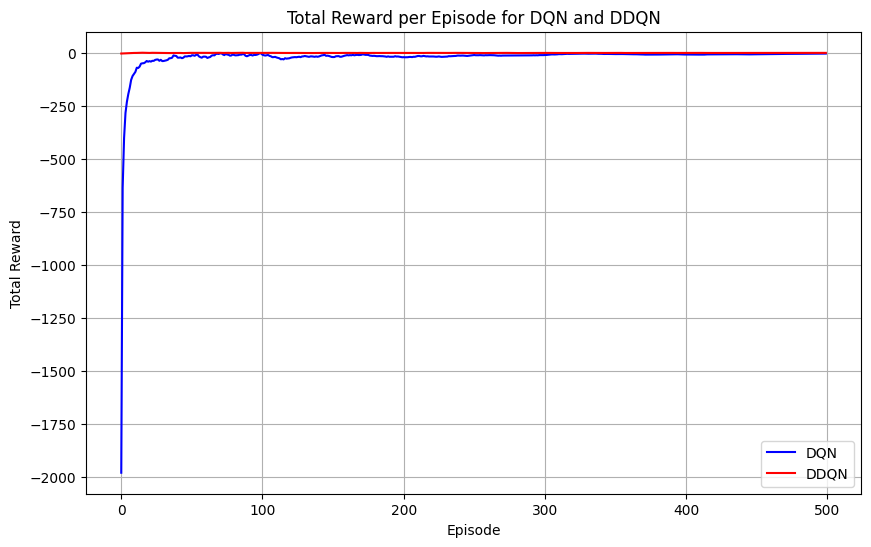

In [18]:
### write your code below this line
# Combine DQN and DDQN Rewards for Comparison Plot
plt.figure(figsize=(10,6))
plt.plot(dqn_rewards, label='DQN', color='blue')
plt.plot(ddqn_rewards, label='DDQN', color='red')

plt.title('Total Reward per Episode for DQN and DDQN')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

### Observations:
1. DQN and DDQN models both learn effectively in this environment.

2. DDQN's advantage is more prominent early on, but after around 100 episodes, the difference between the two models diminishes.
3. Both models converge towards near-optimal performance, but DDQN might have provided a more stable learning process with fewer fluctuations.

This graph suggests that in this specific environment, the benefits of using DDQN over DQN are minimal in the long term, though DDQN may provide a smoother learning curve early on.

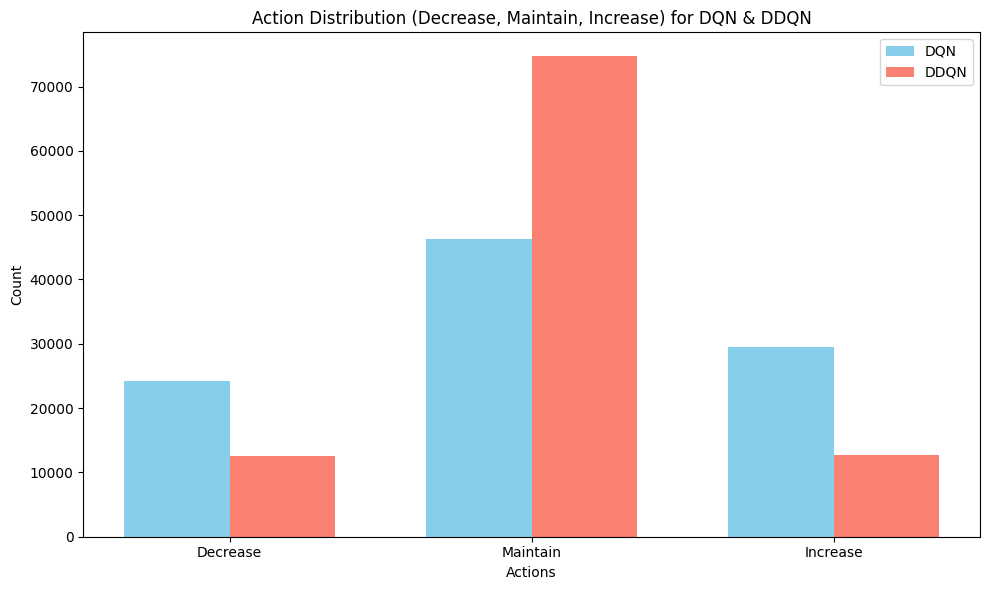

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_action_distribution(dqn_counts, ddqn_counts):
    actions = ['Decrease', 'Maintain', 'Increase']
    dqn_values = [dqn_counts['decrease'], dqn_counts['maintain'], dqn_counts['increase']]
    ddqn_values = [ddqn_counts['decrease'], ddqn_counts['maintain'], ddqn_counts['increase']]

    bar_width = 0.35
    index = np.arange(len(actions))

    plt.figure(figsize=(10, 6))

    # Plot for DQN
    plt.bar(index, dqn_values, bar_width, label='DQN', color='skyblue')

    # Plot for DDQN
    plt.bar(index + bar_width, ddqn_values, bar_width, label='DDQN', color='salmon')

    plt.xlabel('Actions')
    plt.ylabel('Count')
    plt.title('Action Distribution (Decrease, Maintain, Increase) for DQN & DDQN')
    plt.xticks(index + bar_width / 2, actions)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot action distribution
plot_action_distribution(dqn_action_counts, ddqn_action_counts)


### Observations:
1. DDQN takes significantly more "Maintain" actions compared to DQN. This suggests DDQN is more focused on maintaining the current state, likely indicating more stable decision-making.
2. DQN shows a higher count of both "Decrease" and "Increase" actions than DDQN, implying that DQN might be more aggressive or less stable in its actions.

DDQN prioritizes stability by maintaining the current state more often, while DQN takes a more dynamic approach, adjusting the temperature more frequently.

### Conclude your assignment with your analysis consisting of at least 200 words by summarizing your findings for agent’s behaviour using Actor-Critic, DQN and DDQN techniques for optimizing the energy consumption. (1 M)

In [20]:
### write your code below this line

##Analysis of Actor-Critic, DQN, and DDQN for Energy Optimization

In this project, we explored the performance of Actor-Critic, DQN, and DDQN methods to optimize energy consumption in an indoor environment while maintaining occupant comfort.

The **Actor-Critic method** utilizes two neural networks: the Actor for policy optimization and the Critic for value estimation. This technique demonstrated flexibility in managing dynamic environments, but it faced stability issues in learning. Though it gradually improved energy consumption and comfort, its convergence was slower compared to the other methods.

The **DQN approach** performed well in learning optimal temperature adjustments. Its use of a Q-network allowed efficient mapping of states to actions, yielding significant energy savings. However, DQN showed signs of overestimation, especially in highly variable states, and struggled to consistently balance energy savings with occupant comfort. Training was moderately stable, though there were periods of volatile performance due to exploration during learning.

The **DDQN method** addressed the overestimation issue observed in DQN by using a second network for target updates, leading to more stable and reliable learning. DDQN achieved better long-term energy savings and was more effective at maintaining comfort levels. Its ability to produce smoother learning curves with fewer fluctuations made it more suitable for practical applications.

Overall, **DDQN** proved to be the most efficient method in balancing energy consumption and comfort, making it the preferred approach for real-world energy optimization.